# Data Story
Phai Phongthiengtham

## Import necessary modules

In [1]:
import math
import re
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from identify_outlier import *

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 2000)

## Import dataset

In [2]:
dataset_file_name = 'data_10K_no_description.txt'
df = pd.read_csv(dataset_file_name,sep='\t',header=0)

all_edu = ['high_school','associate','bachelor','master','phd']
list_var = ['conml','state','ceq','roe','naics','original_jobtitle','onet'] + all_edu 
df['n'] = 1

df[list_var].head(10)

,conml,state,ceq,roe,naics,original_jobtitle,onet,high_school,associate,bachelor,master,phd
0,Del Taco Restaurants Inc,CA,377.333,0.055423,722513,California,11-9051.00,1,0,0,0,0
1,Medtronic PLC,MN,50294.000,0.080089,334510,I&O Business Development & Technology Sr IT Pr...,11-3021.00,0,0,0,0,0
2,Macy's Inc,AL,4323.000,0.143188,452111,"Macy's Brookwood Village, Birmingham, AL: Huma...",11-3121.00,0,0,0,0,0
3,TE Connectivity Ltd,NJ,8485.000,0.236771,334417,Property Manager,11-9141.00,0,0,1,0,0
4,CA Inc,CA,5689.000,0.136228,511210,"VP, Regional Field Marketing",11-2021.00,0,0,1,1,0
5,Humana Inc.,WI,10685.000,0.057464,621491,Medical Director-HumanaOne and Small Busi,11-9111.00,0,0,0,0,0
6,Darden Restaurants Inc.,GA,2101.700,0.227958,722511,Restaurant Manager,11-9051.00,0,0,0,0,0
7,HSBC Holdings PLC,NY,158276.000,0.015663,522110,Senior Sales Manager Asset Based Lending,11-3031.02,0,0,0,0,0
8,Colliers International Group Inc,GA,205.730,0.330360,531390,Transaction/Construction Coordinator,11-9021.00,0,0,1,0,0
9,DISH Network Corp,CA,4637.119,0.312662,515210,Human Resources Manager - Pacific Region,11-3121.00,0,0,1,0,0


## Occupation

In [3]:
def assign_onet3digit_description(onet):
    
    output = ''
    
    if re.findall(r'\d{2}-\d{1}',onet):
        onet3digit = re.findall(r'\d{2}-\d{1}',onet)[0]
        if onet3digit == '11-1':
            output = '111 : Top Executives'
        elif onet3digit == '11-2': 
            output = '112 : Advertising, Public Relations, and Sales Managers'
        elif onet3digit == '11-3': 
            output = '113 : Operations Managers'
        elif onet3digit == '11-9':
            output = '119 : Other Management Occupations'
            
    return output

df['onet3digit'] = df['onet'].apply(lambda x: assign_onet3digit_description(x))
df['onet3digit'].unique()

array(['119 : Other Management Occupations', '113 : Operations Managers',
       '112 : Advertising, Public Relations, and Sales Managers',
       '111 : Top Executives'], dtype=object)

In [4]:
df_occ = df[['onet3digit','n']]
df_occ = df_occ.groupby(['onet3digit']).count()
df_occ

,n
onet3digit,
111 : Top Executives,1223
"112 : Advertising, Public Relations, and Sales Managers",2672
113 : Operations Managers,2590
119 : Other Management Occupations,3515


## Education Requirement

Next, we look at education requirement:

In [5]:
df_education = df[['onet3digit'] + all_edu]
df_education[all_edu].mean()

high_school    0.0903
associate      0.0595
bachelor       0.5795
master         0.1751
phd            0.0205
dtype: float64

In [6]:
df_education.groupby('onet3digit').mean()

,high_school,associate,bachelor,master,phd
onet3digit,,,,,
111 : Top Executives,0.152903,0.039248,0.527392,0.091578,0.001635
"112 : Advertising, Public Relations, and Sales Managers",0.055763,0.015344,0.681512,0.258608,0.014970
113 : Operations Managers,0.067954,0.030502,0.638610,0.221622,0.015058
119 : Other Management Occupations,0.111238,0.121479,0.476529,0.106401,0.035277


## Profitability

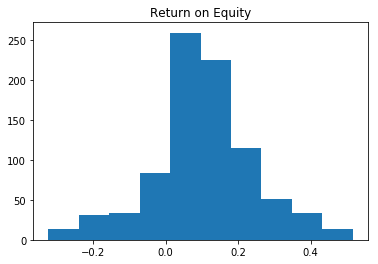

In [7]:
roe_by_firm = df[['conml','roe']].drop_duplicates()
roe_by_firm = roe_by_firm.sort_values('roe')
hist_roe = roe_by_firm.roe

filtered = hist_roe[~is_outlier(hist_roe)]
plt.hist(filtered)
plt.title("Return on Equity")
plt.show()